In [5]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import xgboost as xgb
#import lightgbm as lgb
from catboost import CatBoostClassifier
np.random.seed(25)
import os

In [6]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['font.size'] = 15

In [7]:
train = pd.read_csv("train_jqd04QH.csv")
test = pd.read_csv("test_GYi4Gz5.csv")

In [8]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [9]:
train.isnull().sum(axis=0)

enrollee_id                  0
city                         0
city_development_index       0
gender                    4098
relevent_experience          0
enrolled_university        342
education_level            457
major_discipline          2838
experience                  59
company_size              4779
company_type              5039
last_new_job               367
training_hours               0
target                       0
dtype: int64

In [10]:
train.duplicated().sum()

0

In [11]:
train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                      int64
dtype: object

In [12]:
test['company_size'].unique()

### Group the data with experience then check for other range variables also i.e company_size, last_new_job etc.

array(['1000-4999', '50-99', nan, '<10', '100-500', '10000+', '10/49',
       '5000-9999', '500-999'], dtype=object)

## Handling Null Values

In [13]:
for i in train.columns:
    if i == 'gender':
        train[i].fillna("Other",inplace=True)
    else:
        train[i].fillna(99999,inplace=True)
    
for i in test.columns:
    if i == 'gender':
        test[i].fillna("Other",inplace=True)
    else:
        test[i].fillna(99999,inplace=True)

## Data Visualization(Univariate)

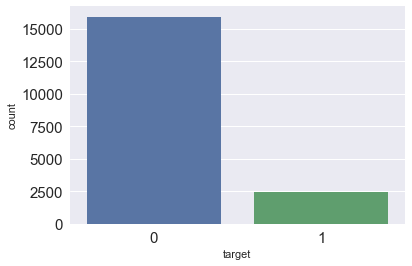

In [14]:
sns.countplot(train['target'])

/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


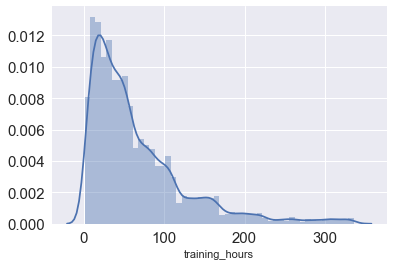

In [15]:
sns.distplot(train['training_hours'])

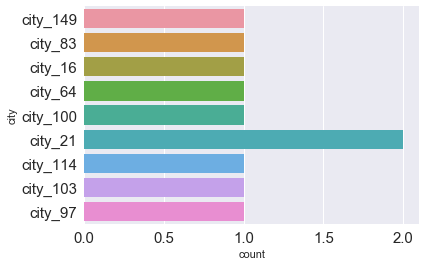

In [16]:
sns.countplot(y=train['city'][:10])

/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


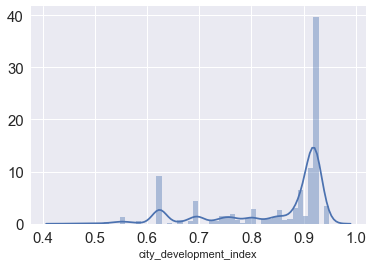

In [17]:
sns.distplot(train['city_development_index'])

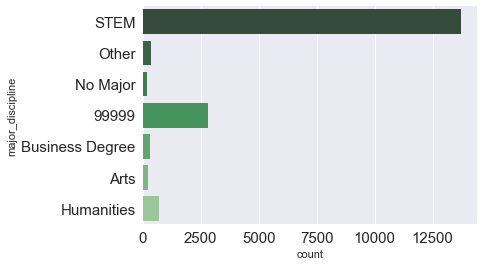

In [18]:
sns.countplot(y="major_discipline", data=train, palette="Greens_d");

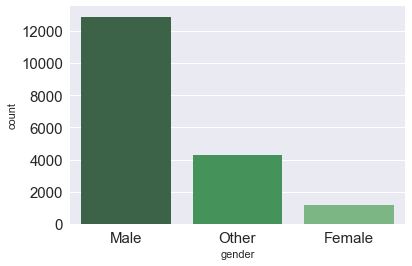

In [19]:
sns.countplot(x="gender", data=train, palette="Greens_d");

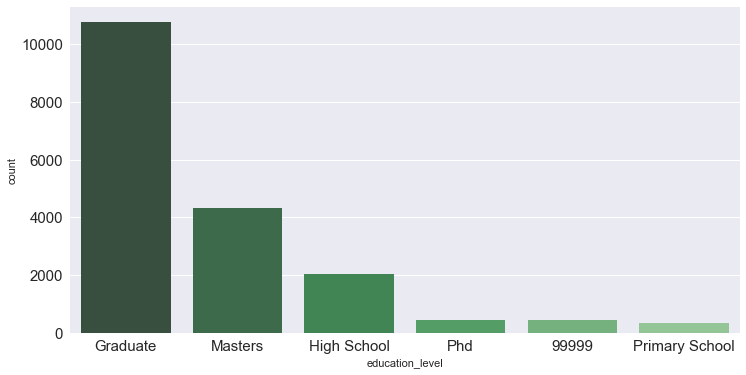

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(x="education_level", data=train, palette="Greens_d");

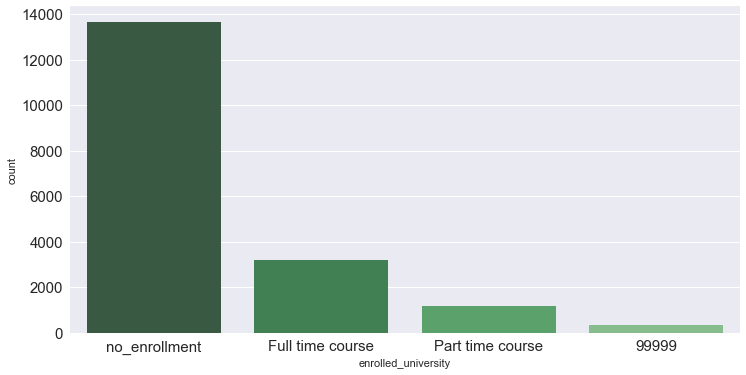

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(x="enrolled_university", data=train, palette="Greens_d");

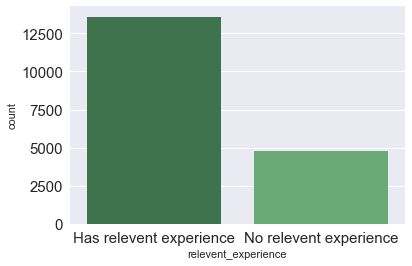

In [22]:
sns.countplot(x="relevent_experience", data=train, palette="Greens_d");

## Data Visualization(Multi-variate)

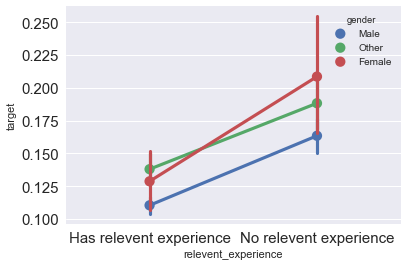

In [23]:
sns.pointplot(y="target", x="relevent_experience", hue="gender", data=train);

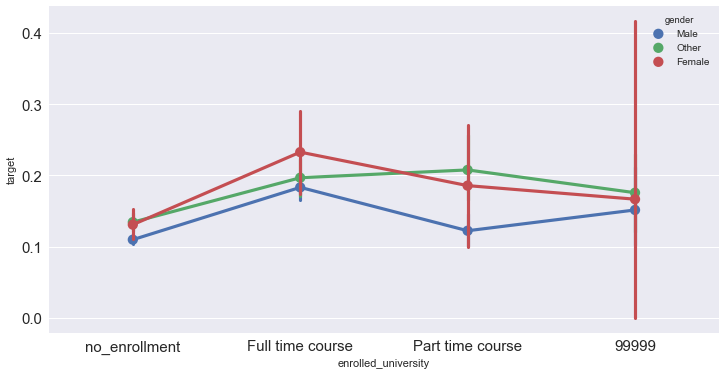

In [24]:
plt.figure(figsize=(12,6))
sns.pointplot(y="target", x="enrolled_university", hue="gender", data=train);

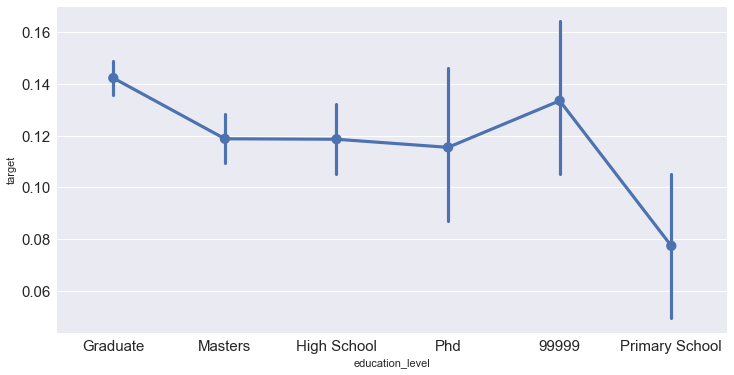

In [25]:
plt.figure(figsize=(12,6))
sns.pointplot(y="target", x="education_level",  data=train);

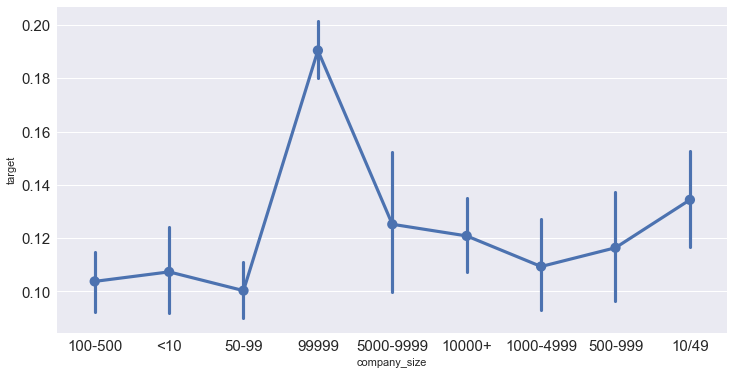

In [26]:
plt.figure(figsize=(12,6))
sns.pointplot(y="target", x="company_size",  data=train);

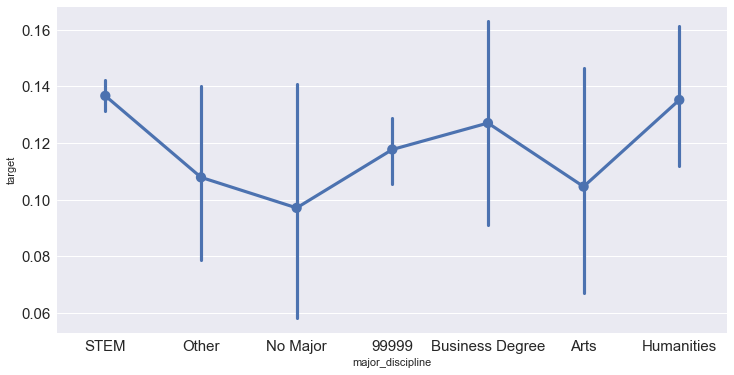

In [27]:
plt.figure(figsize=(12,6))
sns.pointplot(y="target", x="major_discipline", data=train);

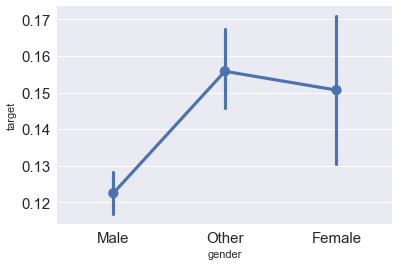

In [28]:
sns.pointplot(y="target", x="gender", data=train);

In [29]:
train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                      int64
dtype: object

In [30]:
# # Label encoding
# from sklearn.preprocessing import LabelEncoder
# lb_make = LabelEncoder()

train['gender'] = train['gender'].astype(str)
test['gender'] = test['gender'].astype(str)
mapping = {'Male':0, 'Female':1, 'Other':2}
train = train.replace({'gender':mapping})
test = test.replace({'gender':mapping})
train['gender'] = train['gender'].astype(float)
test['gender'] = test['gender'].astype(float)

train['city'] = train['city'].str.replace('city_','')
test['city'] = test['city'].str.replace('city_','')
train['city'] = train['city'].astype(int)
test['city'] = test['city'].astype(int)

mapping = {'no_enrollment':0, 'Full time course':1, 'Part time course':2}
train = train.replace({'enrolled_university':mapping})
test = test.replace({'enrolled_university':mapping})
train['enrolled_university'] = train['enrolled_university'].astype(int)
test['enrolled_university'] = test['enrolled_university'].astype(int)

mapping = {'Graduate':0, 'Masters':1, 'High School':2, 'Phd':3, 'Primary School':4}
train = train.replace({'education_level':mapping})
test = test.replace({'education_level':mapping})
train['education_level'] = train['education_level'].astype(int)
test['education_level'] = test['education_level'].astype(int)

mapping = {'STEM':0, 'Other':1, 'No Major':2, 'Business Degree':3, 'Arts':4, 'Humanities':5}
train = train.replace({'major_discipline':mapping})
test = test.replace({'major_discipline':mapping})

mapping = {'<1':0, '>20':25}
train = train.replace({'experience':mapping})
test = test.replace({'experience':mapping})
train['experience'] = train['experience'].astype(int)
test['experience'] = test['experience'].astype(int)

mapping = {'Has relevent experience':0, 'No relevent experience':1}
train = train.replace({'relevent_experience':mapping})
test = test.replace({'relevent_experience':mapping})
train['relevent_experience'] = train['relevent_experience'].astype(int)
test['relevent_experience'] = test['relevent_experience'].astype(int)

mapping = {'100-500':200, '<10':5, '50-99':25, '5000-9999':2500, '10000+': 12000, '1000-4999':2000, '500-999':250, '10/49':20}
train = train.replace({'company_size':mapping})
test = test.replace({'company_size':mapping})

mapping = {'Pvt Ltd':0, 'Funded Startup':1, 'Public Sector':2, 'Early Stage Startup':3, 'NGO':4, 'Other':5}
train = train.replace({'company_type':mapping})
test = test.replace({'company_type':mapping})

mapping = {'>4':5, 'never':0}
train = train.replace({'last_new_job':mapping})
test = test.replace({'last_new_job':mapping})
train['last_new_job'] = train['last_new_job'].astype(float)
test['last_new_job'] = test['last_new_job'].astype(float)

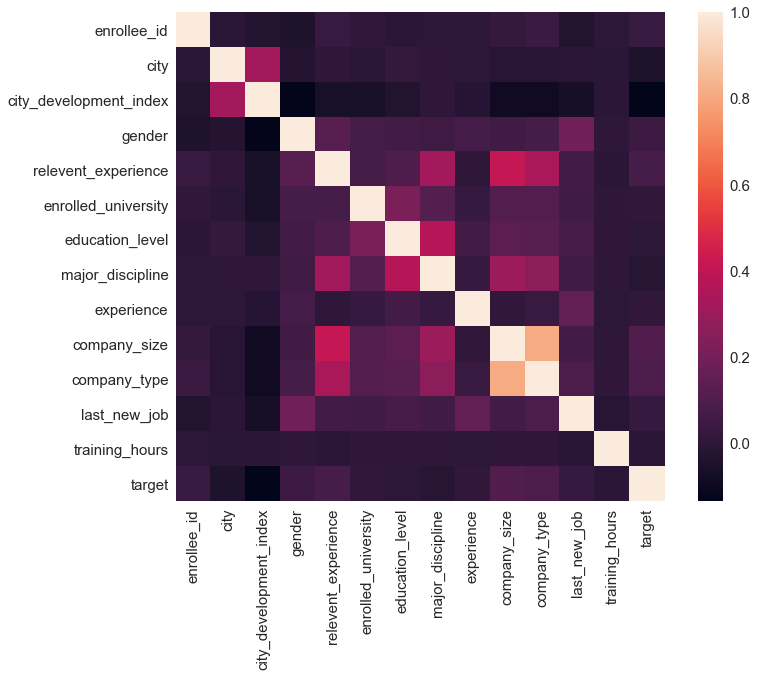

In [31]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

In [32]:
feature_names = [x for x in train.columns if x not in ['enrollee_id', 'target']]
target = train['target']

In [33]:
# ### SMOTE
# #!pip install imbalanced-learn
# from imblearn.over_sampling import SMOTE
# os = SMOTE(random_state=0)

# # now use SMOTE to oversample our train data which have features data_train_X and labels in data_train_y
# os_data_X,os_data_y=os.fit_sample(train[feature_names],target)
# os_data_X = pd.DataFrame(data=os_data_X,columns=feature_names )
# os_data_y= pd.DataFrame(data=os_data_y,columns=["target"])
# # we can Check the numbers of our data
# print("length of oversampled data is ",len(os_data_X))
# print("Number of people not looking for a job in oversampled data",len(os_data_y[os_data_y["target"]==0]))
# print("No.of people looking for a job",len(os_data_y[os_data_y["target"]==1]))
# print("Proportion of Not looking for a job in oversampled data is ",len(os_data_y[os_data_y["target"]==0])/len(os_data_X))
# print("Proportion of looking for a job in oversampled data is ",len(os_data_y[os_data_y["target"]==1])/len(os_data_X))
print(train[feature_names].dtypes)

city                        int64
city_development_index    float64
gender                    float64
relevent_experience         int64
enrolled_university         int64
education_level             int64
major_discipline            int64
experience                  int64
company_size                int64
company_type                int64
last_new_job              float64
training_hours              int64
dtype: object


## Modeling

In [34]:
categorical_features_indices = [0,2,3,4,5,6,7,8,9,11]
model = CatBoostClassifier(iterations=900, depth=8, learning_rate=0.01, eval_metric='AUC', random_seed=42,verbose=False)
## model training and prediction
model.fit(train[feature_names],target,cat_features=categorical_features_indices,plot=True)
pred = model.predict_proba(test[feature_names])[:,1]

MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

In [35]:
model = RandomForestClassifier(max_depth=6,random_state=42,n_estimators=500,max_features='auto',min_samples_leaf=5)
## model training and prediction
model.fit(train[feature_names],target)
pred2 = model.predict_proba(test[feature_names])[:,1]

In [48]:
model = xgb.XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=500,seed=42)
## model training and prediction
model.fit(train[feature_names],target)
pred3 = model.predict_proba(test[feature_names])[:,1]

In [73]:
model = LogisticRegression(class_weight='balanced')
## model training and prediction
model.fit(train[feature_names],target)
pred4 = model.predict_proba(test[feature_names])[:,1]

In [76]:
## make submission
sub = pd.DataFrame()
sub['enrollee_id'] = test['enrollee_id']
sub['target'] = (pred3 * 0.3 + pred * 0.9 + pred2 * 0.5)
sub.to_csv('result.csv', index=False)

In [77]:
sub.head()

,enrollee_id,target
0,16548,0.846983
1,12036,0.131759
2,11061,0.577713
3,5032,0.127874
4,17599,0.160277


/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/anuragsharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


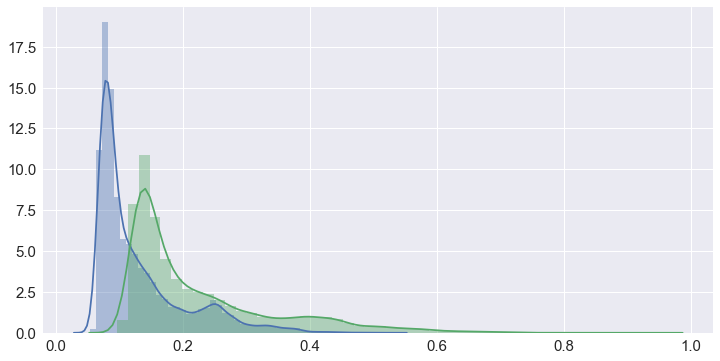

In [72]:
plt.figure(figsize=(12,6))
sns.distplot(pred)
sns.distplot((pred3 * 0.3 + pred * 0.9 + pred2 * 0.5))
#sns.distplot((((pred * 0.50) + (pred2 * 0.5) )))